Compare output from dask streaming analysis to results from Fluctana.

We calculate results from RMCs examples/nersc/check_correlation.py for Channels L1102 and L0906 to
results from the streaming analysis package.


In [51]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib as mpl
mpl.rcParams["xtick.labelsize"] = "large"
mpl.rcParams["ytick.labelsize"] = "large"

import matplotlib.pyplot as plt
from scipy.signal import get_window, detrend

import timeit
import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [285]:
import sys
sys.path.append("/global/homes/r/rkube/repos/delta")

from analysis.tasks_mpi import cross_corr
from analysis.task_fft import task_fft_scipy
from analysis.channels import channel, channel_pair

In [53]:
# Run the fluctana code from RMCs examples/nersc/check_correlation.py

In [134]:
def test_rmc():
    #import sys, os
    #sys.path.append(os.pardir)
    sys.path.append("/global/homes/r/rkube/repos/fluctana_rmc")
    from fluctana import FluctAna, KstarEcei

    # HOW TO RUN
    # ./python3 check_correlation.py 10186 [15.9,16] ECEI_L1303 ECEI_L1403

    shot = 18431 
    trange = [-0.1, -0.08]
    clist = [['ECEI_L1102'], ['ECEI_L0906']]

    # call fluctana
    A = FluctAna()

    # add data
    A.add_data(KstarEcei(shot=shot, clist=clist[0], data_path='/global/cscratch1/sd/rkube/KSTAR/kstar_streaming/'), trange=trange, norm=1)
    A.add_data(KstarEcei(shot=shot, clist=clist[1], data_path='/global/cscratch1/sd/rkube/KSTAR/kstar_streaming/'), trange=trange, norm=1)

    # list data
    A.list_data()

    # do fft; full = 1 
    A.fftbins(nfft=512,window='hann',overlap=0.5,detrend=0,full=1)

    # calculate correlation using data sets done and dtwo. results are saved in A.Dlist[dtwo].val
    A.correlation(done=0, dtwo=1)

    # plot the results; dnum = data set number, cnl = channel number list to plot
    A.mplot(dnum=1,cnl=range(len(A.Dlist[1].clist)),type='val')
    
    return(A)



Rading init: 
Data is normalized by trange average ECEI
LOW signal level channel ECEI_L1102, ref = 100%, siglevel = -0.0003 V
Rading init: 
Data is normalized by trange average ECEI
LOW signal level channel ECEI_L0906, ref = 100%, siglevel = -0.0001 V
---- DATA SET # 0 for [-0.100000, -0.080000] s ----
[000:ECEI_L1102]
---- DATA SET # 1 for [-0.100000, -0.080000] s ----
[000:ECEI_L0906]
dnum 0 fftbins 37 with hann size 512 overlap 0.5 detrend 0 full 1
dnum 1 fftbins 37 with hann size 512 overlap 0.5 detrend 0 full 1


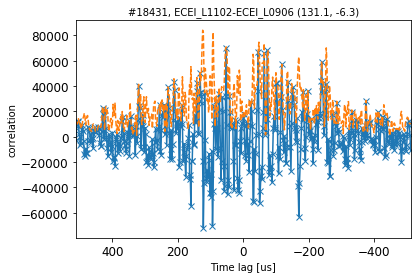

Fluctana takes 1.9263s


In [135]:
tic = timeit.default_timer()
A = test_rmc()
toc = timeit.default_timer()

print("Fluctana takes {0:6.4f}s".format(toc - tic))

In [136]:
def fftbins(x, dt, nfft, window, overlap, do_detrend, full):
    # IN : 1 x tnum data
    # OUT : bins x faxis fftdata
    tnum = len(x)
    
    bins = int(np.fix((int(tnum/nfft) - overlap)/(1.0 - overlap)))
    win = np.hanning(nfft)
    #bins, win = fft_window(tnum, nfft, window, overlap)
    win_factor = np.mean(win**2)  # window factors
    print("***fftbins: win_factor = {0:f}".format(win_factor))

    # make an x-axis #
    ax = np.fft.fftfreq(nfft, d=dt) # full 0~fN -fN~-f1
    if np.mod(nfft, 2) == 0:  # even nfft
        ax = np.hstack([ax[0:int(nfft/2)], -(ax[int(nfft/2)]), ax[int(nfft/2):nfft]])
    if full == 1: # full shift to -fN ~ 0 ~ fN
        ax = np.fft.fftshift(ax)
    else: # half 0~fN
        ax = ax[0:int(nfft/2+1)]

    # make fftdata
    if full == 1: # full shift to -fN ~ 0 ~ fN
        if np.mod(nfft, 2) == 0:  # even nfft
            fftdata = np.zeros((bins, nfft+1), dtype=np.complex_)
        else:  # odd nfft
            fftdata = np.zeros((bins, nfft), dtype=np.complex_)
    else: # half 0 ~ fN
        fftdata = np.zeros((bins, int(nfft/2+1)), dtype=np.complex_)

    for b in range(bins):
        idx1 = int(b*np.fix(nfft*(1 - overlap)))
        idx2 = idx1 + nfft
        #print("***bin {0:d}, idx1 = {1:d}, idx2 = {2:d}".format(b, idx1, idx2))

        sx = x[idx1:idx2]

        if do_detrend == 1:
            sx = detrend(sx, type='linear')
        sx = detrend(sx, type='constant')  # subtract mean
        sx = sx * win  # apply window function

        # get fft
        SX = np.fft.fft(sx, n=nfft)/nfft  # divide by the length
        if np.mod(nfft, 2) == 0:  # even nfft
            SX = np.hstack([SX[0:int(nfft/2)], np.conj(SX[int(nfft/2)]), SX[int(nfft/2):nfft]])
        if full == 1: # shift to -fN ~ 0 ~ fN
            SX = np.fft.fftshift(SX)
        else: # half 0 ~ fN
            SX = SX[0:int(nfft/2+1)]

        fftdata[b,:] = SX

    return ax, fftdata, win_factor

***fftbins: win_factor = 0.374268
(37, 513)
***fftbins: win_factor = 0.374268


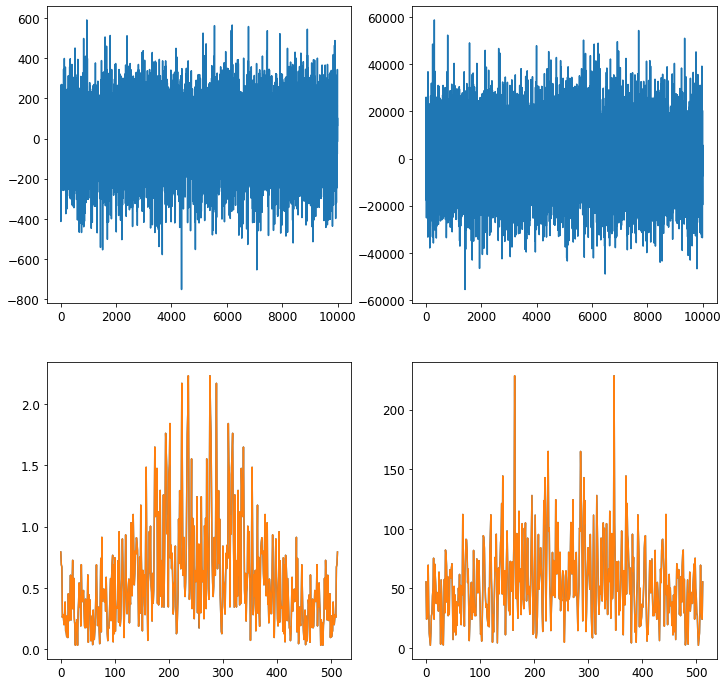

In [147]:
L1102_fa = np.squeeze(A.Dlist[0].data)
L1102_ax, L1102_ft, win_factor = fftbins(L1102_fa, dt=2e-6, nfft=512, window="hann", overlap=0.5, do_detrend=1, full=1)

print(L1102_ft.shape)

L0906_fa = np.squeeze(A.Dlist[1].data)
L0906ax, L0906_ft, win_factor = fftbins(L0906_fa, dt=2e-6, nfft=512, window="hann", overlap=0.5, do_detrend=1, full=1)

plt.figure(figsize=(12,12))
plt.subplot(221)
plt.plot(L1102_fa)
plt.subplot(222)
plt.plot(L0906_fa)

plt.subplot(223)
plt.plot(np.abs(L1102_ft.mean(axis=0)))
plt.plot(np.abs(A.Dlist[0].spdata[0].mean(axis=0)))
plt.subplot(224)
plt.plot(np.abs(L0906_ft.mean(axis=0)))
plt.plot(np.abs(A.Dlist[1].spdata[0].mean(axis=0)))

In [227]:
c1 = channel('L', 11, 2)
c2 = channel('L', 9, 6)

print("Channel 1: ", c1, ", idx = ", c1.idx())
print("Channel 2: ", c2, ", idx = ", c2.idx())

# with np.load("../test_data/cross_correlation_s00001.npz", allow_pickle=True) as df:
#     # Load output of dask
#     res_dask = df["data"]
#     res_dask = np.concatenate(res_dask, axis=0)
#     print("res_dask.shape = ", res_dask.shape)
    
with np.load("../test_data/io_array_s0001.npz") as df:
    # Load raw data, as read by datareader 
    io_array = df["io_array"]
    print("io_array.shape = ", io_array.shape)

with np.load("../test_data/io_array_tr_s0001.npz") as df:
    # Load transformed data, as generated by datareader
    io_array_tr = df["io_array"]
    print("io_array_tr.shape = ", io_array_tr.shape)

with np.load("../test_data/offset_lvl.npz") as df:
    # Load offset data, as calculated by datareader
    offset_lvl = df["offset_lvl"]
    
# with np.load("../test_data/fft_data_s0001.npz") as df:
#     # Load FFT data, as calculated by processor.
#     fft_data = df["fft_data"]
#     print("fft_data.shape = ", fft_data.shape)
    
#_tmp = detrend(io_array, axis=1, type="constant")
#res = stft(_tmp, fs=1./2e-6, nperseg=512, window="hann",
#                 detrend="constant", noverlap=256, padded=False,
#                 return_onesided=False, boundary=None)
#io_array_ft = np.fft.fftshift(res[2], axes=1)
#
#fft_data = np.fft.fftshift(fft_data, axes=1)

print("io_array_tr.shape = ", io_array_tr.shape)
print("Channel idx for ", c1, ": {0:d}".format(c1.idx()), " for ", c1, ", {0:d}".format(c2.idx()))

Channel 1:  L1102 , idx =  81
Channel 2:  L0906 , idx =  69
io_array.shape =  (192, 10000)
io_array_tr.shape =  (192, 10000)
io_array_tr.shape =  (192, 10000)
Channel idx for  L1102 : 81  for  L1102 , 69


In [228]:
io_array_tr.shape

(192, 10000)

In [229]:
with open("config_fft.json", "r") as df:
    config_fft = json.load(df)

In [230]:
config_fft

{'fft_params': {'nfft': 512,
  'window': 'hann',
  'overlap': 0.5,
  'detrend': 'constant',
  'full': True},
 'ECEI_cfg': {'TriggerTime': [-0.12, 61.2, 60],
  't_norm': [-0.119, -0.109],
  'SampleRate': 500,
  'TFcurrent': 23000.0,
  'Mode': 'O',
  'LoFreq': 81,
  'LensFocus': 80,
  'LensZoom': 340}}

In [231]:
config_fft["fft_params"]["fsample"] = config_fft["ECEI_cfg"]["SampleRate"] * 1e3
config_fft["fft_params"]["nfft"] = 512

win = get_window(config_fft["fft_params"]["window"], config_fft["fft_params"]["nfft"])
win_factor = (win**2).mean()
print(f"win_Factor = {win_factor}")


config_fft["fft_params"]["win_factor"] = win_factor

win_Factor = 0.375


In [232]:
my_fft = task_fft_scipy(10_000, config_fft["fft_params"], normalize=True, detrend=True)

In [233]:
fft_data = my_fft.do_fft_local(io_array_tr)

Text(0.5, 1.0, 'Channel L0906')

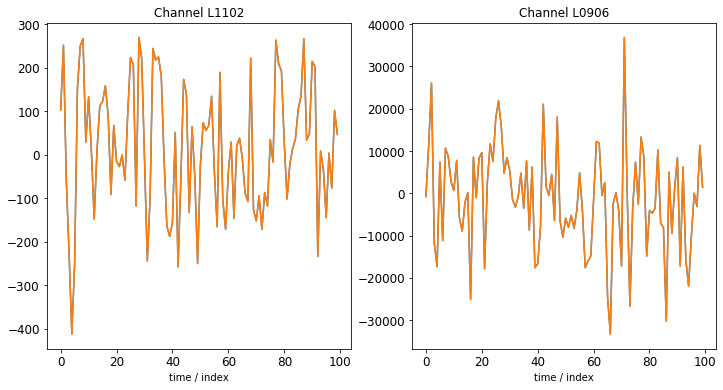

In [237]:
plt.figure(figsize=(12, 6))
plt.subplot(121)

plt.plot(io_array_tr[c1.idx(),:100])
plt.plot(L1102_fa[:100])
plt.xlabel("time / index")
plt.title("Channel " + str(c1))

plt.subplot(122)
plt.plot(io_array_tr[c2.idx(),:100])
plt.plot(L0906_fa[:100])
plt.xlabel("time / index")
plt.title("Channel " + str(c2))

In [239]:
print(np.linalg.norm(io_array_tr[c1.idx(), :] - L1102_fa) / np.linalg.norm(L1102_fa))
print(np.linalg.norm(io_array_tr[c2.idx(), :] - L0906_fa) / np.linalg.norm(L0906_fa))

1.4958554763391102e-12
1.3235043911498094e-10


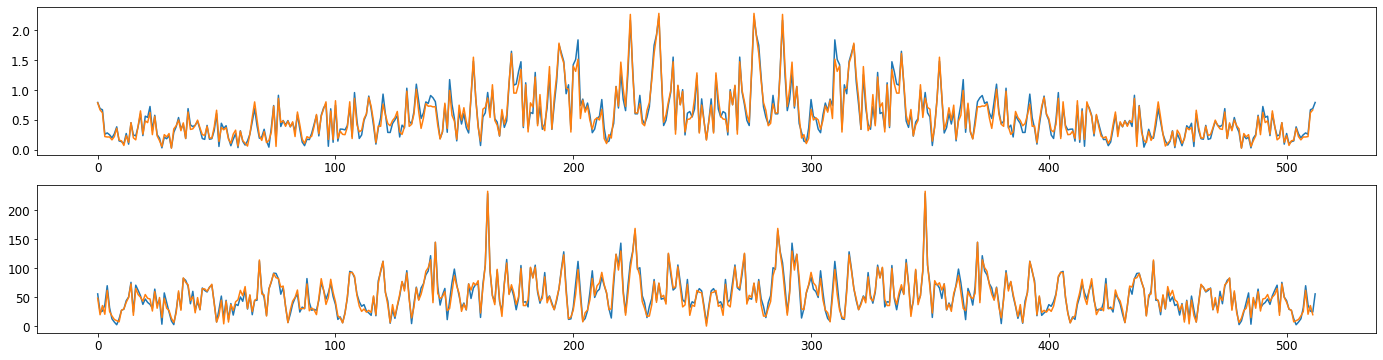

In [241]:
plt.figure(figsize=(24, 6))

plt.subplot(211)
plt.plot(np.abs(L1102_ft.mean(axis=0)))
plt.plot(np.abs(fft_data[c1.idx(), :, :].mean(axis=1)) * 0.5)

plt.subplot(212)
plt.plot(np.abs(L0906_ft.mean(axis=0)))
plt.plot(np.abs(fft_data[c2.idx(), :, :].mean(axis=1) * 0.5))

In [283]:
?np.fft.fftshift

Signature: np.fft.fftshift(x, axes=None)
Docstring:
Shift the zero-frequency component to the center of the spectrum.

This function swaps half-spaces for all axes listed (defaults to all).
Note that ``y[0]`` is the Nyquist component only if ``len(x)`` is even.

Parameters
----------
x : array_like
    Input array.
axes : int or shape tuple, optional
    Axes over which to shift.  Default is None, which shifts all axes.

Returns
-------
y : ndarray
    The shifted array.

See Also
--------
ifftshift : The inverse of `fftshift`.

Examples
--------
>>> freqs = np.fft.fftfreq(10, 0.1)
>>> freqs
array([ 0.,  1.,  2.,  3.,  4., -5., -4., -3., -2., -1.])
>>> np.fft.fftshift(freqs)
array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])

Shift the zero-frequency component only along the second axis:

>>> freqs = np.fft.fftfreq(9, d=1./9).reshape(3, 3)
>>> freqs
array([[ 0.,  1.,  2.],
       [ 3.,  4., -4.],
       [-3., -2., -1.]])
>>> np.fft.fftshift(freqs, axes=(1,))
array([[ 2.,  0.,  1

In [281]:
def my_cross_corr(fft_data, ch_it, fft_params, info_dict):
    
    res = np.zeros([len(ch_it), fft_data.shape[1]])
    print(fft_data.shape)
    for idx, ch_pair in enumerate(ch_it):
        print(ch_pair, ch_pair.ch1.idx(), ch_pair.ch2.idx())
        X = np.fft.fftshift(fft_data[ch_pair.ch1.idx(), :, :])
        Y = np.fft.fftshift(fft_data[ch_pair.ch2.idx(), :, :])
        
        print(X.shape, Y.shape)
        _tmp = np.fft.ifft(X * Y.conj(), axis=0).mean(axis=1) / fft_params["win_factor"]
        print(_tmp.shape)
        res[idx, :] = np.fft.fftshift(_tmp.real)
        
        
        
        #_tmp = np.fft.ifft(X * Y.conj(), n=fft_params['nfft'], axis=0) * fft_params['nfft'] / fft_params['win_factor']
        #res[idx, :] = np.fft.fftshift(_tmp, axes=0).mean(axis=1).real
    
    return(res, info_dict)

In [286]:
# Call the 
ch_it = [channel_pair(c1, c2)]
res, _ = cross_corr(fft_data, ch_it, config_fft["fft_params"], None)
res = np.squeeze(res)

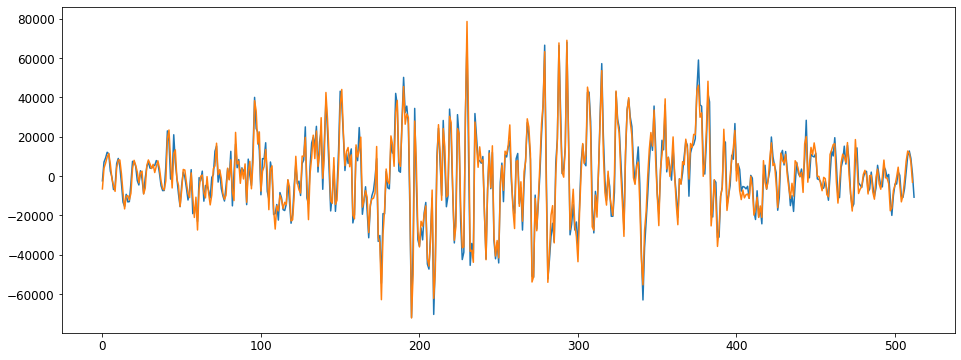

In [287]:
plt.figure(figsize=(16, 6))
plt.plot(A.Dlist[1].val[0])
plt.plot(res * 128)

In [288]:
np.linalg.norm(A.Dlist[1].val[0][1:] - res * 128) / np.linalg.norm(res)

122.63167074248592